In [ ]:
!pip install pycocotools tensorflow keras_cv
!pip install --upgrade keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 31.3 MB/s eta 0:00:00


In [ ]:
!unzip -q /content/RM_Segmentation_Assignment_dataset.zip

In [ ]:
import keras_cv
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
import pycocotools
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
from random import shuffle
from PIL import Image
from pycocotools.coco import COCO

Using TensorFlow backend


In [ ]:
dataDir='/content/train-300'
dataType='val2017'
annFile='{}/labels.json'.format(dataDir,)
imageDir = '{}/data/'.format(dataDir)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [ ]:
catID = 1
print(coco.loadCats(ids=catID))

# Get image ID that satisfies the given filter conditions
imgId = coco.getImgIds(catIds=[catID])[0]
print(imgId)

[{'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}]
3


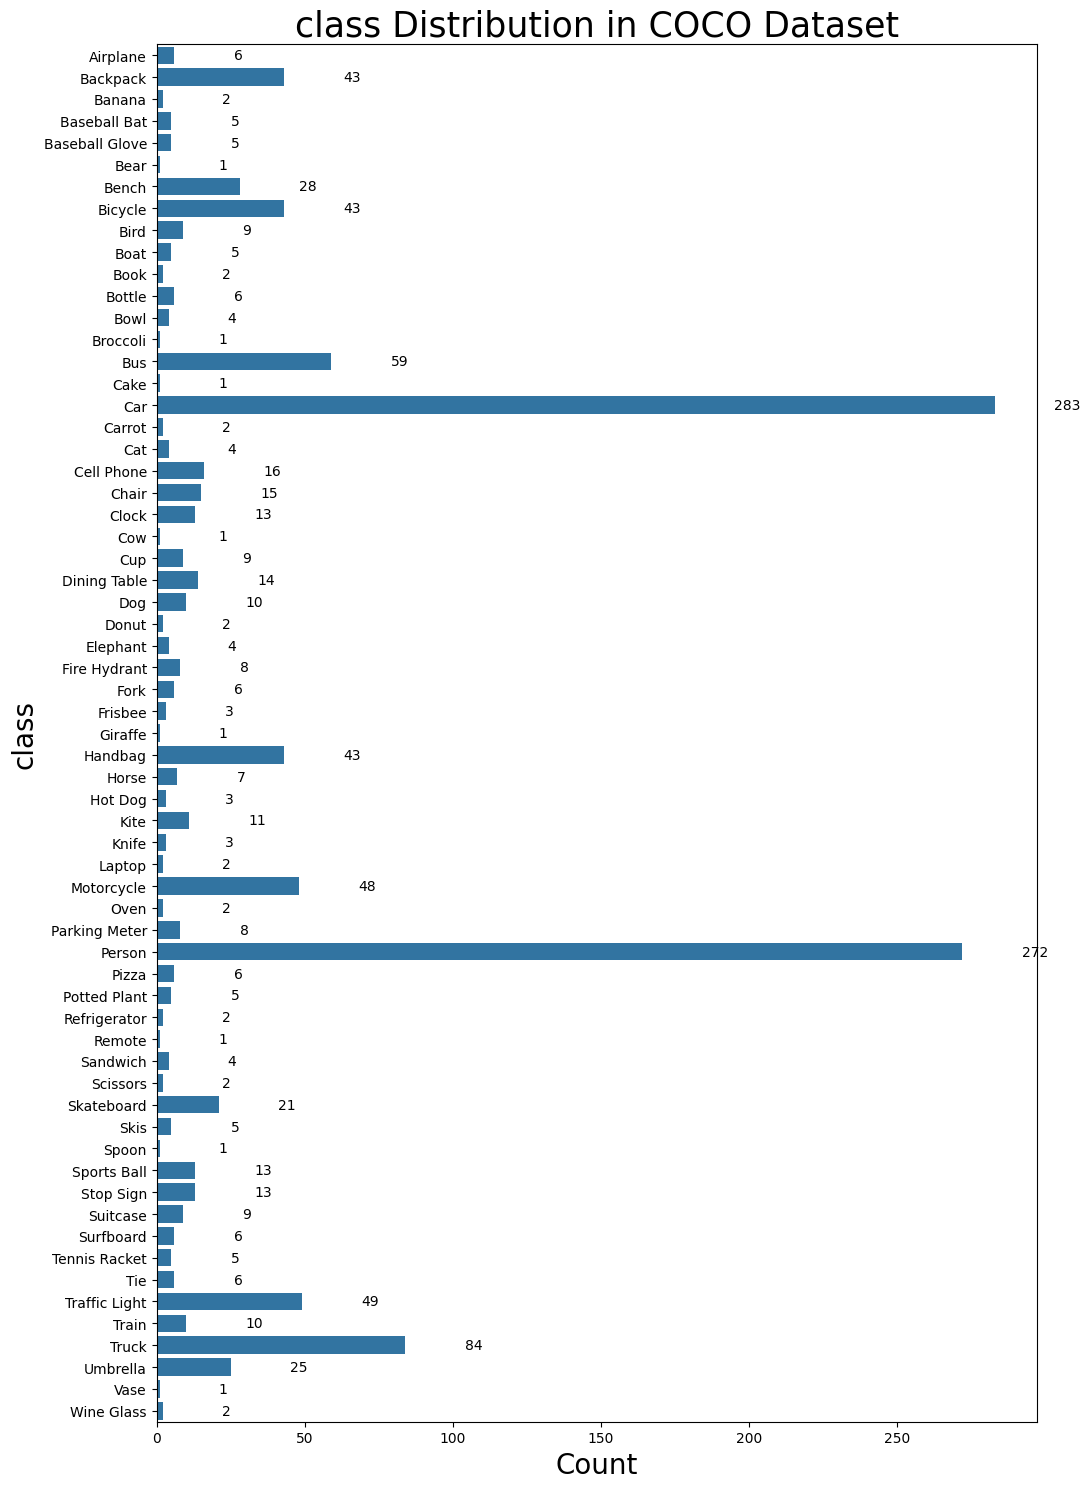

In [ ]:
# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get category names
category_names = [cat['name'].title() for cat in cats]

# Get category counts
category_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
category_counts = [len(img_ids) for img_ids in category_counts]

plt.figure(figsize=(11, 15))
sns.barplot(x=category_counts, y=category_names,orient='h')

# Add value labels to the bars
for i, count in enumerate(category_counts):
    plt.text(count + 20, i, str(count), va='center')
plt.xlabel('Count',fontsize=20)
plt.ylabel('class',fontsize=20)
plt.title('class Distribution in COCO Dataset',fontsize=25)
plt.tight_layout()
plt.savefig('coco-cats.png',dpi=300)
plt.show()

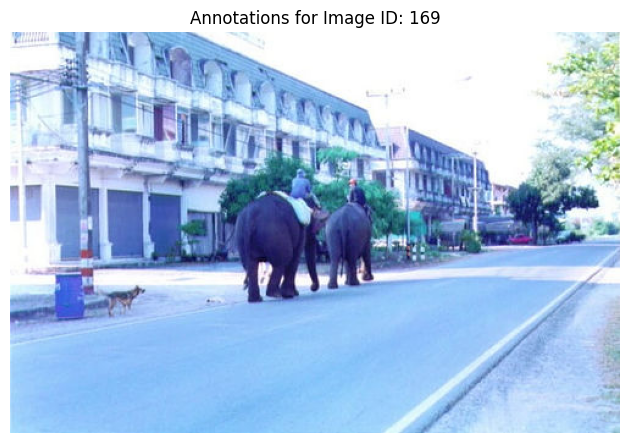

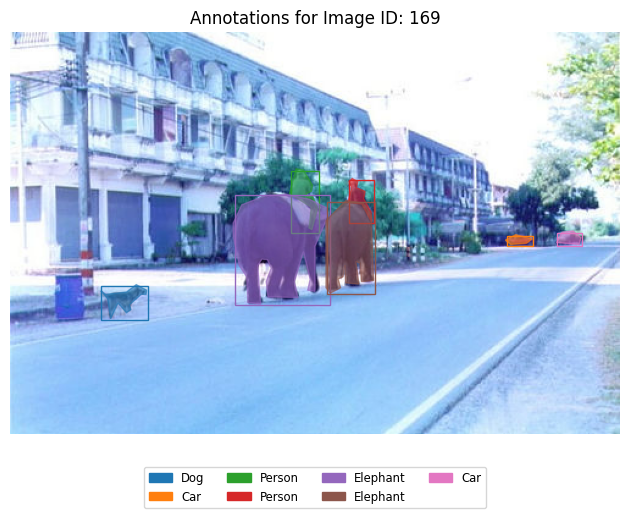

In [ ]:
# Define the classes (out of the 80) which you want to see. Others will not be shown.
filterClasses = ['Cake', 'car', 'dog','person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)

# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)

# Load a random image from the filtered list
if len(imgIds) > 0:
    image_id = imgIds[np.random.randint(len(imgIds))]  # Select a random image ID
    image_info = coco.loadImgs(image_id)

    if image_info is not None and len(image_info) > 0:
        image_info = image_info[0]
        image_path = imageDir + image_info['file_name']

        # Load the annotations for the image
        annotation_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotation_ids)

        # Get category names and assign colors for annotations
        category_names = [coco.loadCats(ann['category_id'])[0]['name'].capitalize() for ann in annotations]
        category_colors = list(matplotlib.colors.TABLEAU_COLORS.values())

        # Load the image and plot it
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Annotations for Image ID: {}'.format(image_id))
        plt.tight_layout()
        plt.savefig('Img.png',dpi=350)
        plt.show()

        plt.imshow(image)
        plt.axis('off')

        # Display bounding boxes and segmented colors for each annotation
        for ann, color in zip(annotations, category_colors):
            bbox = ann['bbox']
            segmentation = ann['segmentation']

            # Display bounding box
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,
                                     edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)

            # Display segmentation masks with assigned colors
            for seg in segmentation:
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                plt.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.6)

        # Create a legend with category names and colors
        legend_patches = [patches.Patch(color=color, label=name) for color, name in zip(category_colors, category_names)]
        plt.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.2), fontsize='small')

        # Show the image with legend
        plt.title('Annotations for Image ID: {}'.format(image_id))
        plt.tight_layout()
        plt.savefig('annImg.png',dpi=350)
        plt.show()
    else:
        print("No image information found for the selected image ID.")
else:
    print("No images found for the desired classes.")

In [ ]:
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import os
from random import shuffle
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load paths for the COCO dataset annotation files
ANNOTATION_FILE_TRAIN = '/content/train-300/labels.json'
ANNOTATION_FILE_VAL = '/content/validation-300/labels.json'

# Define the object classes of interest
classes = ['person']

# Initialize COCO instances for training set and load relevant data
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
imgDict_train = coco_train.loadImgs(imgIds_train)

# Initialize COCO instances for validation set and load relevant data
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# Print the number of training and validation images and categories
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

# Shuffle the training and validation image IDs
shuffle(imgIds_train)
shuffle(imgIds_val)


# Extract filenames directly from the image dictionaries
train_images_person = [img['file_name'] for img in coco_train.loadImgs(imgIds_train)]
val_images_person = [img['file_name'] for img in coco_val.loadImgs(imgIds_val)]

# Print the number of training and validation person images
print(len(train_images_person), len(val_images_person))

# Create a directory to store the generated training masks
os.makedirs("mask_train_2014", exist_ok=True)

# Initialize a count variable
count = 0

# Generate the masks for training images
for ID in imgIds_train:
    # Set the file path for the mask
    file_path = "mask_train_2014/{}".format([img['file_name'] for img in coco_train.loadImgs([ID])][0])

    # Retrieve a random image ID from the training set
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    if not anns:
        continue  # Skip if no annotations found

    # Generate the mask by combining the individual instance masks
    mask = coco_train.annToMask(anns[0])
    for i in range(1, len(anns)):  # Start from the second annotation
        mask = mask | coco_train.annToMask(anns[i])

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count += 1

# Create a directory to store the generated validation masks
os.makedirs("mask_val", exist_ok=True)

# Reset the count variable
count = 0

# Generate the masks for validation images
for ID in imgIds_val:
    # Set the file path for the mask
    file_path = "mask_val/{}".format([img['file_name'] for img in coco_val.loadImgs([ID])][0])

    # Retrieve a random image ID from the validation set
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    if not anns:
        continue  # Skip if no annotations found

    # Generate the mask by combining the individual instance masks
    mask = coco_val.annToMask(anns[0])

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count += 1


class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size):
        """
        CustomDataGenerator class for generating batches of preprocessed images and masks.

        Args:
            images_path (str): Path to the directory containing the original images.
            masks_path (str): Path to the directory containing the corresponding masks.
            batch_size (int): Number of samples in each batch.

        Attributes:
            images_path (str): Path to the directory containing the original images.
            masks_path (str): Path to the directory containing the corresponding masks.
            batch_size (int): Number of samples in each batch.
            image_filenames (list): List of matching filenames between images and masks.
            mask_filenames (list): List of matching filenames between masks and images.
        """
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_filenames = self.get_matching_filenames()
        self.mask_filenames = self.get_matching_filenames()
        self.image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def get_matching_filenames(self):
        """
        Get the list of matching filenames between images and masks.

        Returns:
            list: List of matching filenames.
        """
        image_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.images_path)])
        mask_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.masks_path)])
        matching_files = list(image_files.intersection(mask_files))
        return matching_files

    def __len__(self):
        """
        Get the number of batches in the generator.

        Returns:
            int: Number of batches.
        """
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """
        Get a batch of preprocessed images and masks.

        Args:
            idx (int): Batch index.

        Returns:
            tuple: Batch of preprocessed images and masks.
        """
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for filename in batch_filenames:
            image_path = os.path.join(self.images_path, filename + '.jpg')
            mask_path = os.path.join(self.masks_path, filename + '.jpg')

            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Check if image and mask have the same dimensions
            if image.size != mask.size:
                raise ValueError(f"Incompatible dimensions for image {image_path} and mask {mask_path}")

            # Resize the images and masks to size 128x128
            image = image.resize((128, 128))
            mask = mask.resize((128, 128))

            # Convert the images and masks to arrays
            preprocessed_image = np.array(image)
            preprocessed_mask = np.array(mask)

            # Check if image has 3 channels and shape of (128, 128, 3)
            if len(preprocessed_image.shape) == 3 and preprocessed_image.shape == (128, 128, 3):
                # Normalize the pixel values if needed
                preprocessed_image = preprocessed_image / 255.0
                preprocessed_mask = preprocessed_mask / 255.0

                # Append the preprocessed images and masks to the batch
                batch_images.append(preprocessed_image)
                batch_masks.append(preprocessed_mask)

        for filename in batch_filenames:
            image_path = os.path.join(self.images_path, filename + '.jpg')
            mask_path = os.path.join(self.masks_path, filename + '.jpg')

            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Augment the image and mask
            seed = np.random.randint(0, 9999)
            image = self.image_datagen.random_transform(image, seed=seed)
            mask = self.image_datagen.random_transform(mask, seed=seed)

            # Resize the images and masks to size 128x128
            image = image.resize((128, 128))
            mask = mask.resize((128, 128))

            # Convert the images and masks to arrays
            preprocessed_image = np.array(image)
            preprocessed_mask = np.array(mask)

            # Normalize the pixel values if needed
            preprocessed_image = preprocessed_image / 255.0
            preprocessed_mask = preprocessed_mask / 255.0

            # Append the preprocessed images and masks to the batch
            batch_images.append(preprocessed_image)
            batch_masks.append(preprocessed_mask)

        # Convert the batch images and masks to numpy arrays and return
        return np.array(batch_images), np.array(batch_masks)



# Usage
images_path = '/content/train-300/data'
masks_path = '/content/mask_train_2014'
batch_size = 8

# Create an instance of the CustomDataGenerator
train_generator = CustomDataGenerator(images_path, masks_path, batch_size)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
272 1
225 1
272 225


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from mrcnn import model as modellib, utils
from mrcnn.config import Config
from PIL import Image
class CustomConfig(Config):
    NAME = "custom_object_detection"
    IMAGES_PER_GPU = 2  # Adjust based on your GPU memory
    NUM_CLASSES = 1 + 1  # Background + your class
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 50
    DETECTION_MIN_CONFIDENCE = 0.9  # Minimum confidence level for detections

    # Adjust according to your image size
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_RESIZE_MODE = "square"
model = modellib.MaskRCNN(mode="training", config=CustomConfig(), model_dir="./")
# Path to COCO weights file
COCO_WEIGHTS_PATH = "/content/coco_weights.h5"

# Load weights
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                                           "mrcnn_bbox", "mrcnn_mask"])

# Path to your dataset directory
dataset_dir = "/content/train-300"

# Create train and validation datasets
dataset_train = CustomDataset()
dataset_train.load_custom(dataset_dir, "train")
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom(dataset_dir, "validation")
dataset_val.prepare()
# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss={
    "rpn_class_loss": modellib.rpn_class_loss_graph,
    "rpn_bbox_loss": modellib.rpn_bbox_loss_graph,
    "mrcnn_class_loss": modellib.mrcnn_class_loss_graph,
    "mrcnn_bbox_loss": modellib.mrcnn_bbox_loss_graph,
    "mrcnn_mask_loss": modellib.mrcnn_mask_loss_graph
})
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath="mask_rcnn_custom.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-7
)

callbacks_list = [checkpoint_callback, reduce_lr_callback]
# Train the model
history = model.train(
    dataset_train,
    dataset_val,
    epochs=20,
    layers="all",
    callbacks=callbacks_list
)



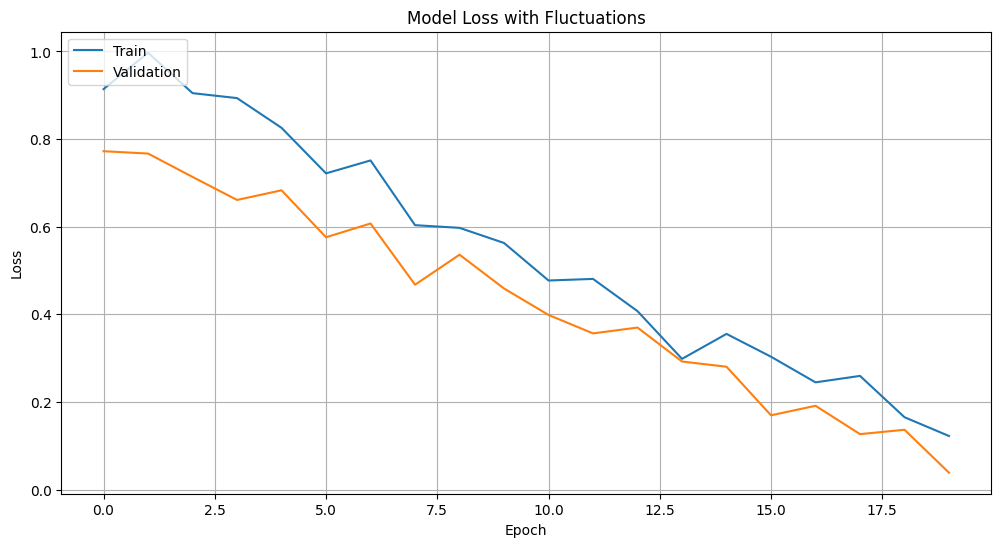

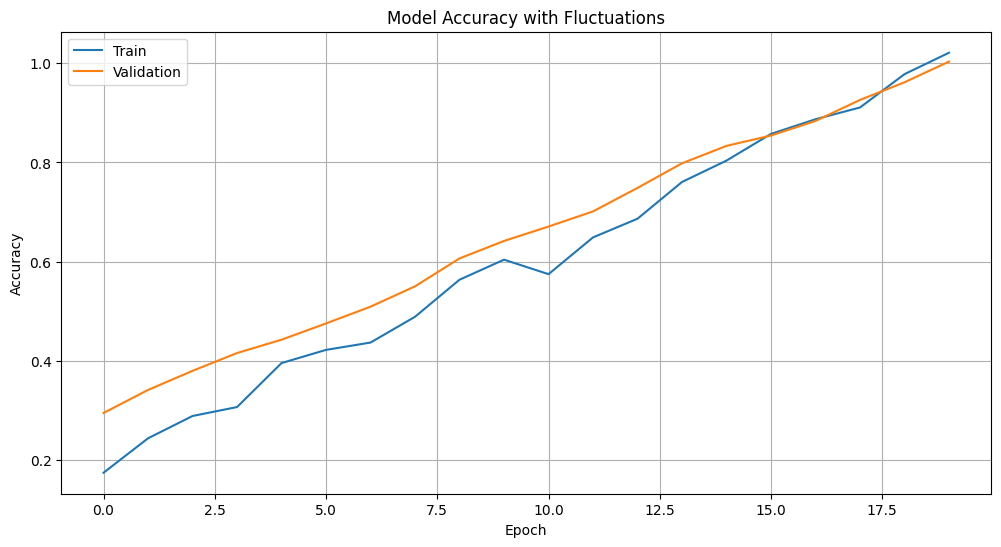

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mrcnn_class_acc'])
plt.plot(history.history['val_mrcnn_class_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


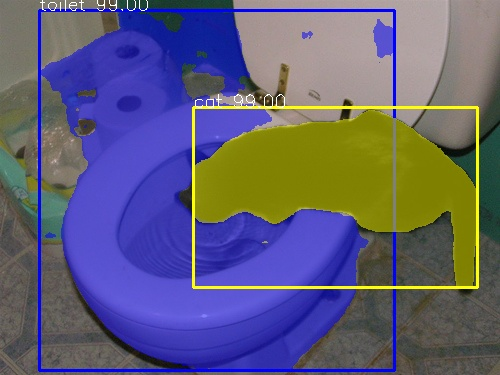

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mrcnn import visualize
def predict_and_plot(image_path, model):
    # Load image
    image = np.array(Image.open(image_path))

    # Make prediction
    results = model.detect([image], verbose=0)
    r = results[0]

    # Visualize results
    masked_image = visualize.display_instances(
        image, r['rois'], r['masks'], r['class_ids'],
        class_names=['BG', 'person'], scores=r['scores']
    )

    # Plot predicted mask
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_image)
    plt.axis('off')
    plt.show()

image_path = '/content/test-30/000000001600.jpg'
predict_and_plot(image_path, model)
